## Open db and read LV_reviews table created in sqloader
LV_Reviews is join of reviews on LV_Businesses <br>
LV_Businesses is new table created from exported Las Vegas business subset json

In [3]:
%%time
import pandas as pd
import gc
import sqlite3
from sqlite3 import Error
import os

import nltk
import string
import re

from textblob import TextBlob
import matplotlib.pyplot as plt


Wall time: 1.39 s


In [4]:
# Paths to unprocessed dataset files
prefix = '../data/'
filePaths = {
    "reviews": prefix + 'yelp_academic_dataset_review.json',
    "businesses": prefix + 'yelp_academic_dataset_business.json',
    "checkins": prefix + 'yelp_academic_dataset_checkin.json',
    "tips": prefix + 'yelp_academic_dataset_tip.json',
    "users": prefix + 'yelp_academic_dataset_user.json',
    "db": prefix + 'yelp.db'
}
PATH = os.path.abspath(os.path.dirname('__file__') + "labeled_cleaned_restaurants.json")
labeledRestaurants = pd.read_json(PATH, orient='records')

### Read json files

In [5]:
%%time
# --------------------------------------------------------------------------
#  Filter reviews for our cleaned and labeled restaurants
# --------------------------------------------------------------------------

# Load the review json
reviewReader = pd.read_json(
    filePaths['reviews'], 
    lines=True,
    chunksize=1000
)

# Filter reviews using the business_id from our cleaned business json
chunk_list = []
for reviewChunk in reviewReader:
    reviewChunk = pd.merge(
        labeledRestaurants[['business_id']], 
        reviewChunk, 
        on='business_id', 
        how='inner'
    )
    chunk_list.append(reviewChunk)

# Merge chunks into a single dataframe
filtered_reviews = pd.concat(chunk_list, ignore_index=True, axis=0)

# Print how many reviews were extracted from the original dataset
print(f'found: {len(filtered_reviews)} reviews')
    

found: 831370 reviews
Wall time: 2min 24s


### Connect to DB

In [5]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            return conn

db_file = filePaths['db']
conn = create_connection(db_file=db_file)

c = conn.cursor()

2.6.0


In [6]:
%%time
rev0 =  pd.read_sql_query("Select * from LV_Reviews", conn)
conn.close()

Wall time: 9.26 s


In [7]:
rev0.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,bVTjZgRNq8ToxzvtiVrqMA,2hRe26HSCAWbFRn5WChK-Q,d4qwVw4PcN-_2mK2o1Ro1g,1,0,0,0,10pm on a super bowl Sunday and they're alread...,2015-02-02 06:28:00,Pink Taco,...,Las Vegas,NV,89169,36.109706,-115.154021,1120,1,"{""RestaurantsTakeOut"": ""True"", ""BusinessAccept...","Mexican, Restaurants","{""Monday"": ""11:0-22:0"", ""Tuesday"": ""11:0-22:0""..."


Wall time: 35.9 ms


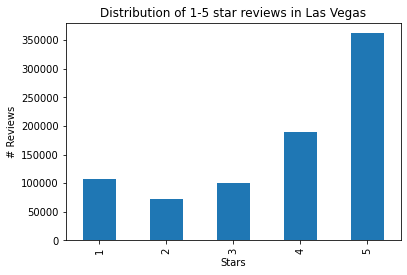

In [8]:
%%time
fig = rev0['stars'].value_counts().sort_index().plot(kind='bar',xlabel="Stars", ylabel="# Reviews", title="Distribution of 1-5 star reviews in Las Vegas")

In [9]:
reviews = rev0

In [10]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,...,city,state,postal_code,latitude,longitude,review_count,is_open,attributes,categories,hours
0,bVTjZgRNq8ToxzvtiVrqMA,2hRe26HSCAWbFRn5WChK-Q,d4qwVw4PcN-_2mK2o1Ro1g,1,0,0,0,10pm on a super bowl Sunday and they're alread...,2015-02-02 06:28:00,Pink Taco,...,Las Vegas,NV,89169,36.109706,-115.154021,1120,1,"{""RestaurantsTakeOut"": ""True"", ""BusinessAccept...","Mexican, Restaurants","{""Monday"": ""11:0-22:0"", ""Tuesday"": ""11:0-22:0""..."
1,TeX0eOIeZb_wpo86rCedXQ,RR-2nouBn408e3djxC470g,d4qwVw4PcN-_2mK2o1Ro1g,5,0,0,0,Holy heck this place is amazing. I love their ...,2017-02-09 04:25:03,Pink Taco,...,Las Vegas,NV,89169,36.109706,-115.154021,1120,1,"{""RestaurantsTakeOut"": ""True"", ""BusinessAccept...","Mexican, Restaurants","{""Monday"": ""11:0-22:0"", ""Tuesday"": ""11:0-22:0""..."
2,NHQWhZve7UEaGLt7IwAyDw,H3wPBzQCKCKiHcV7GZK4kg,LkMtMHVetws5_7QfRjPtlg,2,5,3,4,This actually used to be one of my favorite ho...,2011-01-09 00:09:50,LVH - Las Vegas Hotel & Casino,...,Las Vegas,NV,89109,36.136257,-115.151253,944,0,"{""NoiseLevel"": ""u'average'"", ""RestaurantsDeliv...","Casinos, Nightlife, Restaurants, Hotels & Trav...","{""Monday"": ""6:0-6:0"", ""Tuesday"": ""6:0-6:0"", ""W..."
3,TkcxD1A4N_9kRZwGhUjDKA,bgG0jJyUXta_kczGrQW2Rw,7EZ4Eu7YJ1ltRCC5jXFJrQ,1,1,0,0,There wasn't one specific thing that made this...,2013-04-10 16:19:12,Corner Market Buffet,...,Las Vegas,NV,89109,36.124829,-115.171991,824,1,"{""NoiseLevel"": ""u'average'"", ""RestaurantsDeliv...","Asian Fusion, Event Planning & Services, Resta...","{""Monday"": ""7:0-22:0"", ""Tuesday"": ""7:0-22:0"", ..."
4,8qdikDQ0bkJj7QZa2IdvrQ,7MXunAzrmnbBd0XQR33zaA,nJcyfIRGbI31EGLzillWYg,1,0,0,0,A margarita in clear plastic dickie cup??? Wtf...,2015-01-18 16:12:27,Vince Neil's Tatuado EAT DRINK PARTY,...,Las Vegas,NV,89109,36.137112,-115.163311,448,1,"{""Ambience"": ""{'touristy': True, 'hipster': Fa...","Breakfast & Brunch, Nightlife, Bars, American ...","{""Monday"": ""7:0-0:0"", ""Tuesday"": ""7:0-0:0"", ""W..."


In [11]:
import nltk
import string
import re

In [12]:
# ntlk requested install via this statement
#nltk.download('stopwords')

In [13]:
# ntlk requested install via this statement
#nltk.download('stopwords')

### Simply Review text
(takes about 8 minutes to run)

In [14]:
%%time
def preprocess(x):
    x = re.sub('[^a-z\s]', '', x.lower())                 
    x = [w for w in x.split() if w not in set(stopwords)]  
    return ' '.join(x)

i = nltk.corpus.stopwords.words('english')
j = list(string.punctuation)
stopwords = set(i).union(j)

#simplifies review text to lowercase, removes symbols and stopwords
rev0['text2'] = rev0['text'].apply(preprocess)

Wall time: 1min 58s


In [15]:
#take a look at what is being filtered out
nltk.corpus.stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Analyze sentiment on simplified review text
(takes about 8 minutes to run)

In [16]:
from textblob import TextBlob
def senti(x):
    return TextBlob(x).sentiment 

In [17]:
%%time
# creates new column on simple text for sentiment scores
# takes a bit to run
rev0['senti_score'] = rev0['text2'].apply(senti)

Wall time: 4min 6s


### Seperate sentiment tuple into two new columes for ease of use
I also threw this full df into a .csv to avoid re-running the above code

In [18]:
# seperate sentiment score tuple into two new columns
rev0[['polarity', 'subjectivity']] = pd.DataFrame(rev0['senti_score'].tolist(), index=rev0.index)

In [18]:
rev0.groupby('stars')['polarity'].mean()

stars
1   -0.051413
2    0.088804
3    0.192460
4    0.289899
5    0.376189
Name: polarity, dtype: float64

In [17]:
# rev0.to_csv("C:\\Users\\pajuc\\Documents\\yelp\\data\\rev_sent.csv")
# df = pd.read_csv("C:\\Users\\pajuc\\Documents\\yelp\\data\\rev_sent.csv")

In [21]:
# del rev0
# df.head()

### Couple different looks at the sentiment and location

In [14]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Las Vegas')

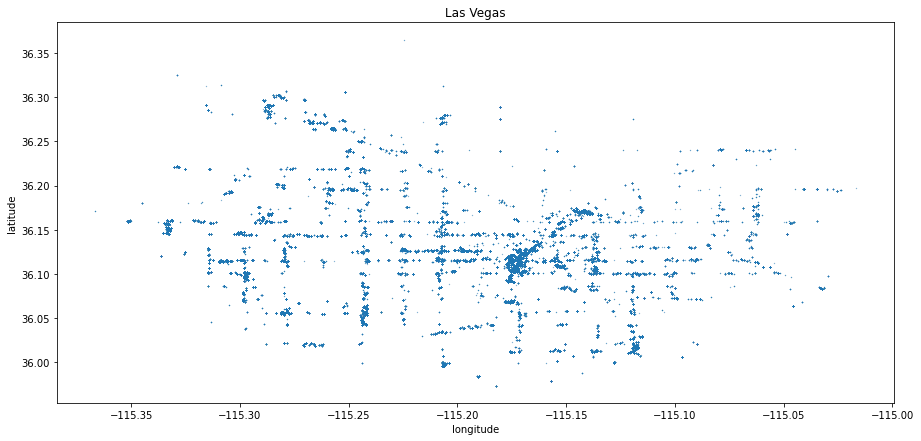

In [21]:
df = rev0
f, ax1 = plt.subplots(1, 1, figsize=(15,7))
df.plot(kind='scatter', x='longitude', y='latitude', s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Las Vegas")

In [22]:
import seaborn as sns

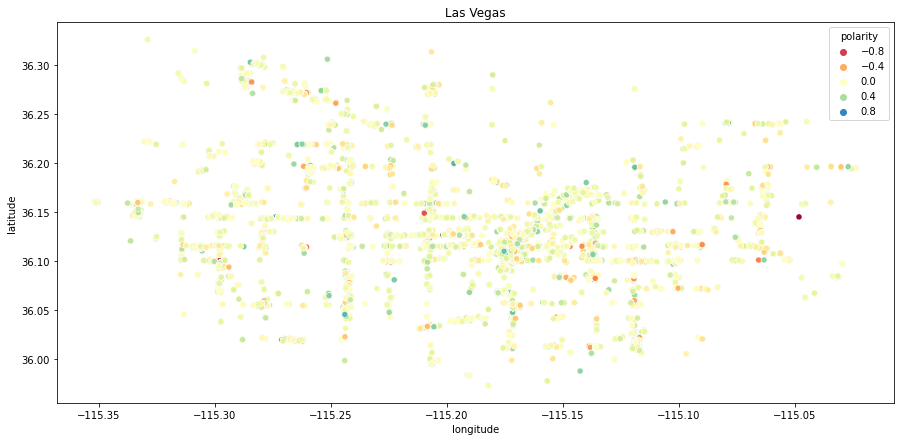

In [25]:
f, ax1 = plt.subplots(1, 1, figsize=(15,7))
ax1.set_title("Las Vegas")
sns.scatterplot(data=df[df.stars==2], x='longitude', y='latitude', hue='polarity', palette='Spectral')
plt.show()

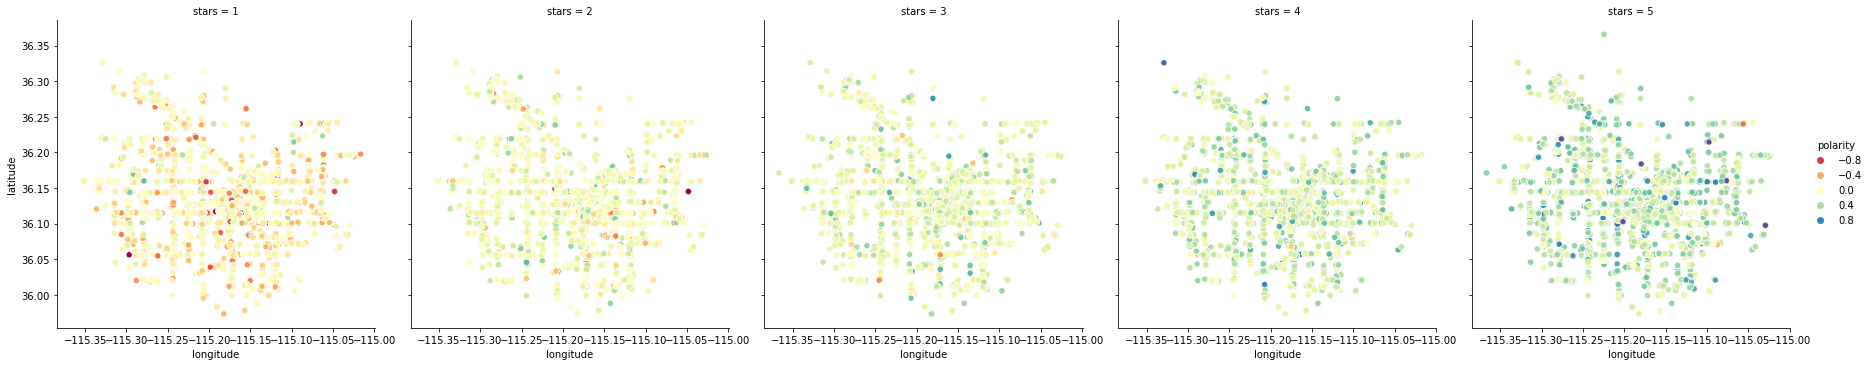

In [26]:
sns.relplot(
    data=df, x='longitude', y='latitude', hue='polarity',
    col="stars", palette='Spectral',
    kind="scatter"
)

All areas contain 1-5 star businesses. Sentiment varies over whole range for these business as well.
Maybe using 'quality' reviewers will clean this up a bit.

In [27]:
df['date'] = pd.to_datetime(df['date'])

In [28]:
business_list = df['name'].drop_duplicates()

In [29]:
business_list

0                                    Pink Taco
2               LVH - Las Vegas Hotel & Casino
3                         Corner Market Buffet
4         Vince Neil's Tatuado EAT DRINK PARTY
5                                  Dirty South
                          ...                 
810514            MYTH: Legends of the Artisan
811511         Haddies Car Wash El Capitan Way
812495                 Honolulu Cookie Company
813518                  The Underground Lounge
814195                          La Rosticceria
Name: name, Length: 3038, dtype: object

<AxesSubplot:xlabel='date', ylabel='polarity'>

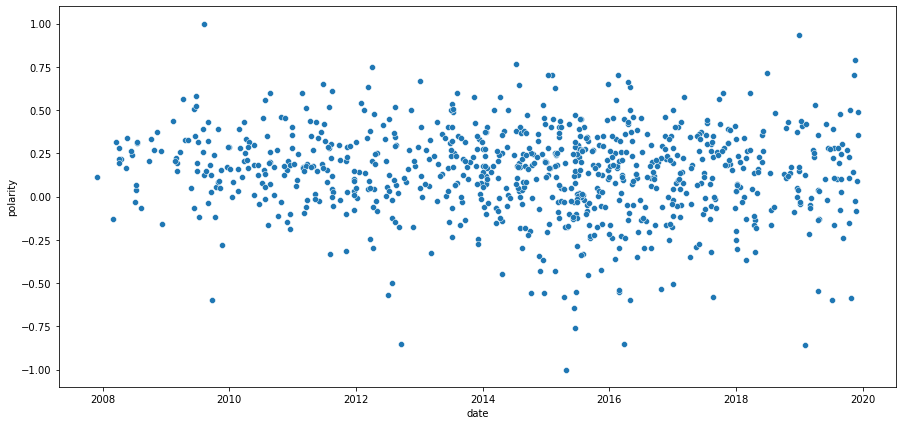

In [30]:
f, ax1 = plt.subplots(1, 1, figsize=(15,7))

sns.scatterplot(data=df[df.name=='Corner Market Buffet'], x='date', y='polarity')

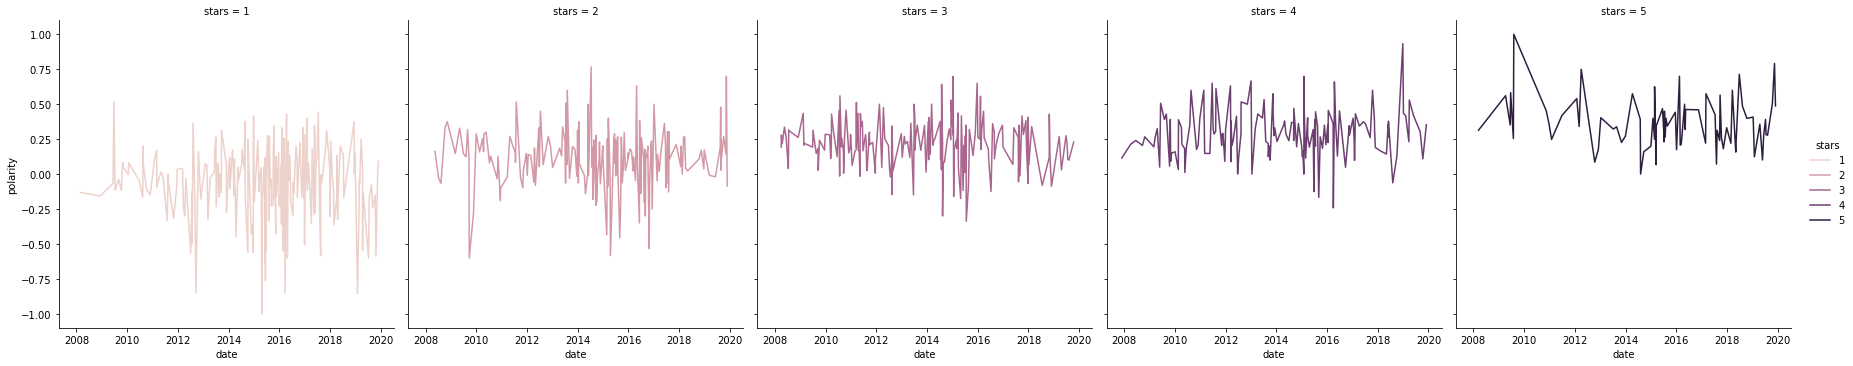

In [31]:
sns.relplot(data=df[df.name=='Corner Market Buffet'], x='date', y='polarity', kind='line', col='stars', hue='stars')

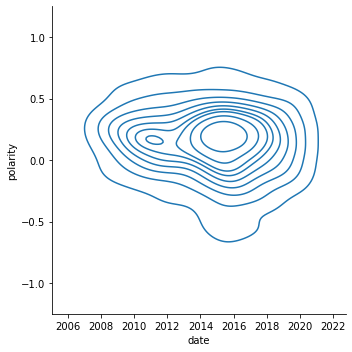

In [32]:
sns.displot(data=df[df.name=='Corner Market Buffet'], x='date', y='polarity', kind='kde')

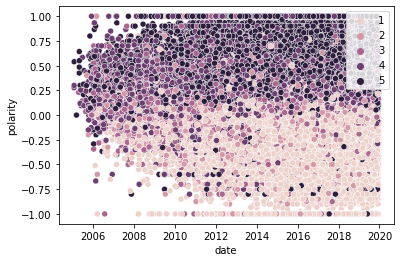

In [34]:
sns.scatterplot(data=df, x='date', y='polarity', hue='stars')
plt.legend(loc='upper right')
plt.show()

### TODO
Re-run sentiment_assessments to drill down into keywords

In [180]:
sample_review = df['text2'][0]

In [181]:
sample_review

'pm super bowl sunday theyre already closed weak wonder hard rock dying'

In [182]:
t = TextBlob(sample_review).sentiment_assessments

In [183]:
t

Sentiment(polarity=-0.10833333333333334, subjectivity=0.4833333333333333, assessments=[(['super'], 0.3333333333333333, 0.6666666666666666, None), (['closed'], -0.1, 0.1, None), (['weak'], -0.375, 0.625, None), (['hard'], -0.2916666666666667, 0.5416666666666666, None)])

### TODO
Plot Vegas street map as background in lat/lon figure (GeoPandas)
Break plotting into groups like rating/category/stars and show distributions via kde plot (i.e. show best area for tacos)

### TODO
Seasonal changes?
Quick look at sentiment for one business didn't show noticable patterns over time...

In [186]:
gc.collect()

30

# Topics on bad reviews
https://www.kaggle.com/devmaxime/finding-topics-in-yelp-s-bad-reviewsm

In [35]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [37]:
df_badreviews = df.loc[df.stars < 2]
df_badreviews.shape

(107341, 25)

In [38]:
texts = []
for review in df_badreviews.text:
    texts.append(review)

### Cleaning techniques #1 : Tokenization

In [39]:
%%time
tokenizer = nltk.RegexpTokenizer(r'\w+')

texts_tokens = []
for i, val in enumerate(texts):
    text_tokens = tokenizer.tokenize(val.lower())
    
    for i in range(len(text_tokens) - 1, -1, -1):
        if len(text_tokens[i]) < 4:
            del(text_tokens[i])

    texts_tokens.append(text_tokens)
    
texts_tokens[:1]

Wall time: 5.12 s


[['10pm',
  'super',
  'bowl',
  'sunday',
  'they',
  'already',
  'closed',
  'weak',
  'wonder',
  'hard',
  'rock',
  'dying']]

### Cleaning techniques #2 : Removing stopwords

In [41]:
stopWords = set(stopwords.words('english'))

In [42]:
%%time
texts_filtered = []

for i, val in enumerate(texts_tokens):
    text_filtered = []
    for w in val:
        if w not in stopWords:
            text_filtered.append(w)
    texts_filtered.append(text_filtered)


texts_filtered[:1]

Wall time: 1.04 s


[['10pm',
  'super',
  'bowl',
  'sunday',
  'already',
  'closed',
  'weak',
  'wonder',
  'hard',
  'rock',
  'dying']]

In [43]:
len(texts_filtered)


107341

### Cleaning techniques #3 : Lemma

In [45]:
wordnet_lemmatizer = WordNetLemmatizer()

In [46]:
%%time
texts_lem = []

for i, val in enumerate(texts_filtered):
    text_lem = []
    for word in val:
        text_lem.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    texts_lem.append(text_lem)
    
texts_lem[:1]

Wall time: 16.5 s


[['10pm',
  'super',
  'bowl',
  'sunday',
  'already',
  'close',
  'weak',
  'wonder',
  'hard',
  'rock',
  'die']]

In [47]:
len(texts_lem)

107341

### Joinning

In [48]:
texts_string = []
for text in texts_lem:
    string = ' '
    string = string.join(text)
    texts_string.append(string)

In [49]:
texts_string[:10]

['10pm super bowl sunday already close weak wonder hard rock die',
 'specific thing make buffet horrible accumulation everything less average quality plenty options none flavorful worth fill others comment dessert section worthwhile everything taste unthaw stale side asian section probably best offer still fairly bland worst part go grab slice pizza station someone place tongs directly pizza hand germs direct contact food workers right think disgust would discard slice husband leave unsatisfied stomach look forward second dinner would hours later much better establishment',
 'margarita clear plastic dickie drunkin shrimp plate call goldfish feeder shrimp platter',
 'drive fruit root almost daily finally decide give unfortunately good thing place nice decor walk greet girls look menu ask first time tell assume would explain menu nope daughter strawberry banana smoothie menu smoothies strawberry banana mix stuff ask would able make strawberry banana say already make continue look menu di

In [58]:
texts_string_subset = texts_string[:30000]

# Models to Minie Topics in Reviews

## LDA

In [59]:
# shrink corpus for testing purposes
corpus = texts_string_subset

In [60]:
%%time

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
feature_names =  vectorizer.get_feature_names()

Wall time: 969 ms


In [61]:
%%time
n_topics = 10

lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=200
)

lda.fit_transform(X)

Wall time: 21min 38s


array([[0.00833531, 0.0083353 , 0.39732066, ..., 0.00833564, 0.00833422,
        0.00833814],
       [0.0013702 , 0.07418247, 0.12213877, ..., 0.00137011, 0.00137011,
        0.09434088],
       [0.00769309, 0.07837488, 0.43125958, ..., 0.00769349, 0.43651241,
        0.00769296],
       ...,
       [0.00714384, 0.00714345, 0.00714382, ..., 0.00714347, 0.93570409,
        0.00714587],
       [0.00434783, 0.00434831, 0.00434805, ..., 0.00434801, 0.00434809,
        0.00434794],
       [0.87488594, 0.00212793, 0.00212831, ..., 0.10808922, 0.00212793,
        0.0021279 ]])

In [55]:
lda.n_iter_

4

In [56]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, feature_names, no_top_words)

Topic 0:
location customer service call place time give even close would
Topic 1:
food order come wait service say table time tell would
Topic 2:
order wait come service time drink take minutes never go
Topic 3:
order chicken food like fry taste come place good back
Topic 4:
room stay hotel like would go come place people time
Topic 5:
breakfast taste egg cake like go cream steak price crab
Topic 6:
food place service good buffet like vegas worst better price
Topic 7:
food table place like service restaurant even would leave price
Topic 8:
order food pizza place time like come sushi back take
Topic 9:
room call hotel tell stay check say charge would card
